# RUN PERFORMANCE PROJECT - Pau Sampietro 

## *Predicting future races:* WEIGHTED LINEAR REGRESSION ALGORITHM

Both of the previous algorithms (LR and KNN) perform a regression without taking into account how old or recent the moves are. If, for exemple, we perform two different times for the same race in two consecutive years, the model does not weight as more relevant the most recent move, and it should be (as the time has an influence on the performance).

For that reason, we decide to try a linear regression (that provided us better results) but considering now **that the most recent moves are more relevant than the older ones**, which means **weighting our regression**. We will consider this equation to calculate weights:

 > **W = K * exp(-timeElapsed/T)**

*where K is a scaling constant and T is the time-constant for the decay function. time Elapsed is measured as days from the move has been done. W works as case-weight* 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table
from datetime import datetime

#### Import table moves from Pau from the Database

In [3]:
moves = read_table('moves_feat')

In [5]:
moves.drop(columns='index', inplace=True)
moves.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,4019.0,280.0,69.7,670.0,166.0,659,29.8
1,4995.0,63.0,12.6,585.0,168.0,659,30.9
2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,6540.0,241.0,36.9,760.0,161.0,637,42.0


### 1. Adding weights to the model 

#### 1.1. Computing and Plotting weights based on "days_from" column

Loop through many weight functions to find the optimal parameter T. We force that:
* **weight = 1** for a move done today
* **weight = 0.5** for a move done 1 year from now

Choosen parameter K is: 1
Choosen parameter T is: 526


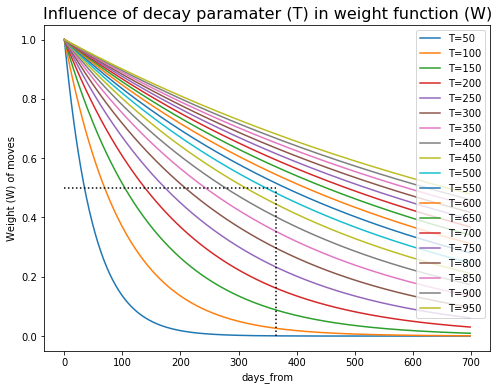

In [51]:
K = 1
x = [i for i in range(0,700)]
plt.figure(figsize=(8,6))
for T in range(50,1000,50):
    y = [K * np.exp(-i/T) for i in x]
    plt.plot(x, y)

plt.title('Influence of decay paramater (T) in weight function (W)', fontsize=16)
plt.legend([f'T={i}' for i in range(50,1000,50)], loc=1)
plt.plot(range(365),[0.5 for i in range(365)], 'black', linestyle=':')
plt.plot([365 for i in range(100)], [0.005*i for i in range(100)], 'black', linestyle=':')
plt.ylabel('Weight (W) of moves')
plt.xlabel('days_from')

# Printing the choosen parameters
print(f'Choosen parameter K is: {K}')
print(f'Choosen parameter T is: {int(-365/np.log(0.5))}')

#### 1.2. Applying decayment function with choosen parameters K,T

In [6]:
moves['w'] = moves.apply(lambda x: x['start_time']).days, axis = 1)

#### 1.2. Filtering only relevant features

In [7]:
moves_fil = moves.drop(columns = 'index').reset_index()
moves_fil = moves_fil[['distance','accum_ascent','ascent_ratio','calories','heart_rate','days_from','moving_time']]
moves_fil.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,4019.0,280.0,69.7,670.0,166.0,659,29.8
1,4995.0,63.0,12.6,585.0,168.0,659,30.9
2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,6540.0,241.0,36.9,760.0,161.0,637,42.0


In [8]:
len(moves_fil)

143

* ***We store the table with the appropiate features in order to perform further regressions in other notebooks (4b, 4c...)***

In [9]:
export_table(moves_fil, 'moves_feat', METHOD='replace')

### 2. Preliminar Pairplot of features & Heatmap 

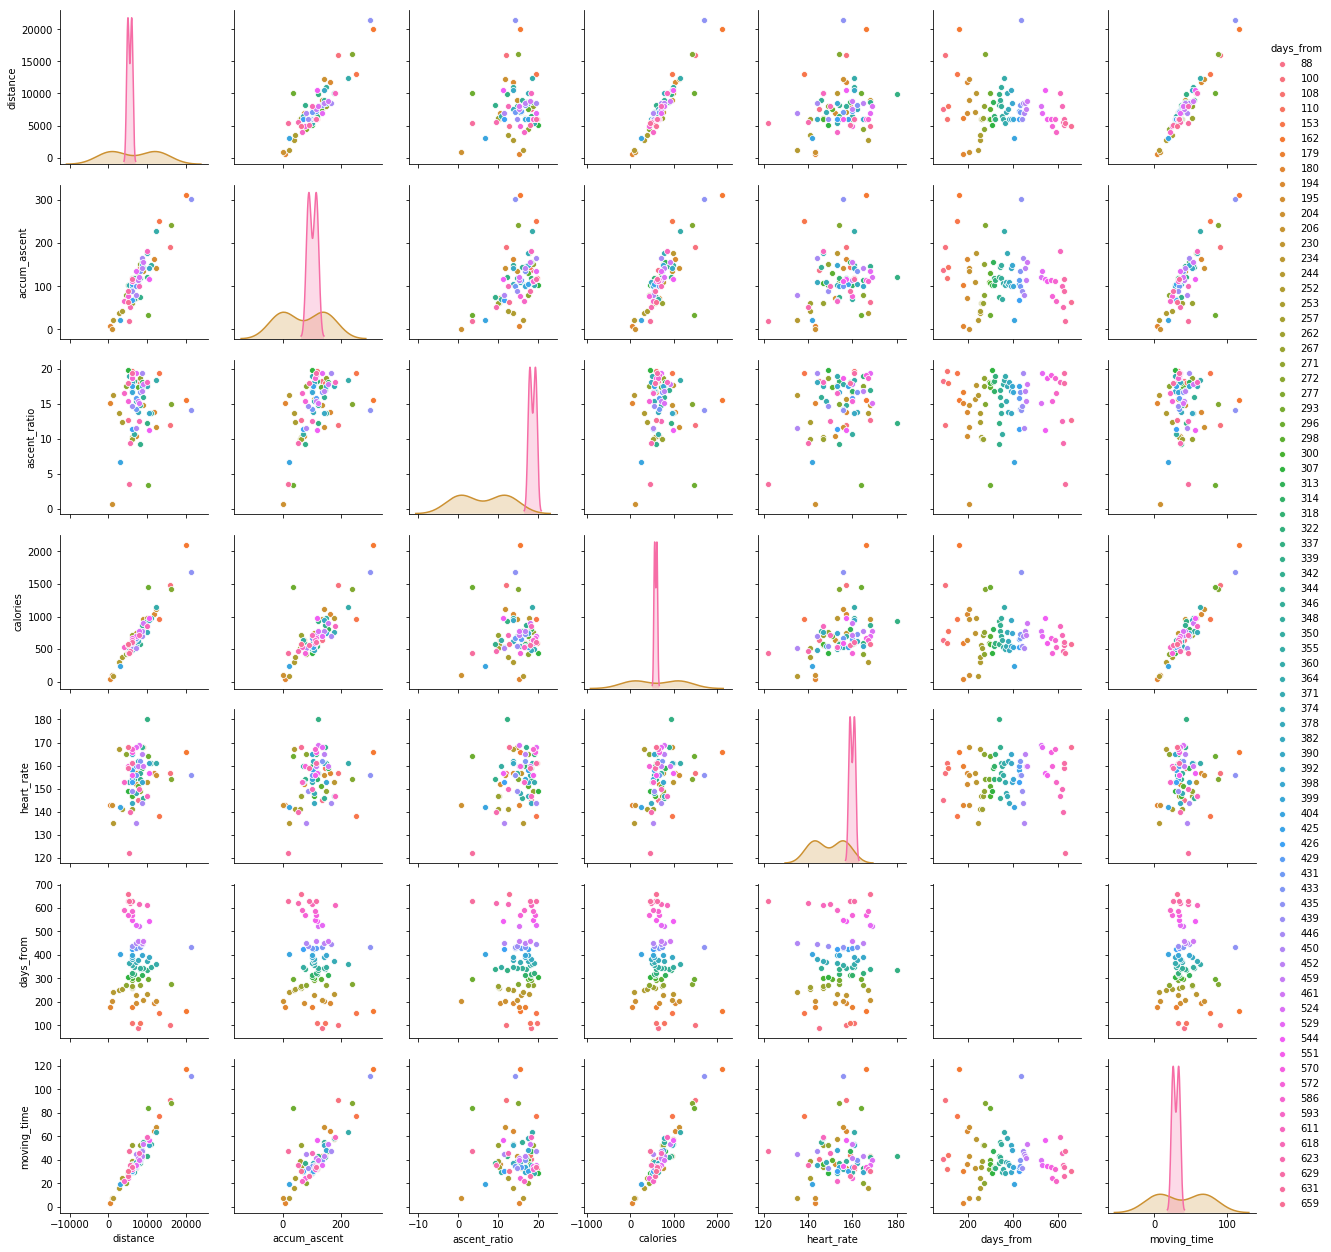

In [67]:
sns.pairplot(moves_fil, hue='days_from')

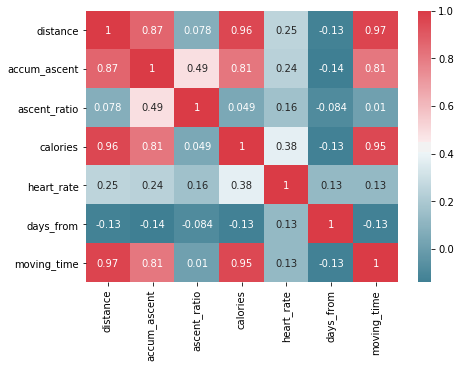

In [70]:
corr = moves_fil.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### 3. Linear Regression Algorithm

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

The goal is to know what will be the times for two given races:
* Delta Prat Race: 10 km, 25 m ascent, 5 may 2019
* Marathon Catllaràs: 42 km, 2700 m ascent, 19 may 2019
* Stockholm Marathon: 42 km, 172 m ascent, 1 june 2019
* Trail Ulldeter: 21 km, 1300 m ascent, 23 june 2019

In [10]:
races_names = pd.Series(['delta prat', 'catllaras', 'stockholm', 'ulldeter'])
races_dist = pd.Series([10000.0, 42300.0, 42195.0, 21000.0])
races_asc = pd.Series([25.0, 2700.0, 172.0, 1300.0])
races_to = pd.Series([-13, -27, -40, -62])

races = pd.DataFrame({'name': races_names, 'distance': races_dist, 'accum_ascent': races_asc, 'days_from': races_to})
races

,name,distance,accum_ascent,days_from
0,delta prat,10000.0,25.0,-13
1,catllaras,42300.0,2700.0,-27
2,stockholm,42195.0,172.0,-40
3,ulldeter,21000.0,1300.0,-62


* Store races DataFrame for further analysis

In [11]:
export_table(races, 'races')

#### 3.1. Applying linear regression with all the features

In [24]:
X = moves_fil.drop(columns='moving_time')
y = moves_fil['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [25]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predictions done with the model
y_pred = linear_reg.predict(X_test)

In [26]:
# The coefficients
print('Coefficients:', linear_reg.coef_)
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: [ 2.45530260e-04 -2.88140618e-03  1.03252253e-01  6.98092901e-02
 -9.33327544e-01  6.97872228e-03]
* Mean squared error: 46.54
* Variance score: 0.97


*As we can see, the result of the r2 score is very high. That means the data is well explained by the model, but we still have a mean squared error quite big. This model is probably overfitting our data, and will not be able to generalize pretty well future given inputs.*

* Performing **cross-validation** score

In [27]:
scores = cross_val_score(linear_reg, X,  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.89071548 0.95836185 0.97700316 0.95087096 0.95434278]
* Mean Variance score: 0.95


#### 3.2. Model with only two features: Distance & Accumulated ascent

In [28]:
X = moves_fil[['accum_ascent','distance']]
y = moves_fil['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [29]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predictions done with the model
y_pred = linear_reg.predict(X_test)

In [30]:
# The coefficients
print('Coefficients:', linear_reg.coef_)
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: [0.11677722 0.00338874]
* Mean squared error: 154.32
* Variance score: 0.89


In [31]:
scores = cross_val_score(linear_reg, X,  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.70754061 0.91185059 0.94255492 0.84742461 0.84566975]
* Mean Variance score: 0.85


#### 3.3. Calculating predictions for next given races with actual model:

In [32]:
linear_reg.fit(X, y)

races_lr_pred = linear_reg.predict(races[['accum_ascent','distance']])
print(f'* LR predictions for given races: {races_lr_pred}')

* LR predictions for given races: [ 36.63950814 452.95048311 163.87062203 219.99027765]


* Including results of linear regression predictions in the races dataframe

In [33]:
races['lr_pred'] = races_lr_pred

*** *COMMENTS***: Althought the r2 score of this model is pretty high, the results above show that there are a misunderstanding of some data from the linear model. The two main conlusions, based on our knowledge of Pau's previous marks are:
* Cross-country races are predict very well. **Catllaras: 452 min ~ 7:30h / Ulldeter: 219 min ~ 3:45h** (last year time!)
* Urban races are badly predicted **36 min for a 10 km** and **2:45h for a marathon** are for professional athletes !!!